# import

In [30]:
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time,datetime
import variable_bin_methods as varbin_meth
import variable_encode as var_encode
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc,confusion_matrix,recall_score,precision_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from feature_selector import FeatureSelector
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
import missingno as msno
import matplotlib
#matplotlib.use(arg='Qt5Agg')
import matplotlib.pyplot as plt
matplotlib.rcParams['font.sans-serif']=['SimHei']   
matplotlib.rcParams['axes.unicode_minus']=False  
#from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore") ##忽略警告

# 函数定义

In [31]:
######子函数
##删除缺失值多的样本
def del_na(df,colname_1,rate):
    ##df: dataframe
    ##colname_1: 列名list
    ##rate:缺失值比例，大于rate变量删除
    na_cols = df[colname_1].isna().sum().sort_values(ascending=False)/float(df.shape[0])
    na_del = na_cols[na_cols >= rate]
    print ('\n'.join(["变量缺失值多,该变量被删除 {} ".format(i) for i in na_del.index]))
    df = df.drop(na_del.index, axis=1)
    return df,na_del
##目标变量映射字典
def target_mapping(lst):
    ##Late (31-120 days)、Default、Charged Off映射为1，坏样本
    ##Late (16-30 days)、In Grace Period映射为2,不确定样本
    ##Current、Fully Paid映射为0，好样本
    mapping = {}
    for elem in lst:
        if elem in ["Charged Off",'Late (16-30 days)', "Late (31-120 days)" ]:
            mapping[elem] = 1
        elif elem in ['In Grace Period']:
            mapping[elem] = 2
        elif elem in ['Current','Fully Paid']:
            mapping[elem] = 0
        else:
            mapping[elem] = 3
    return mapping   
# 删除常量
def constant_del(df, cols):
    dele_list = []
    for col in cols:
        # remove repeat value counts
        uniq_vals = list(df[col].unique())
        if pd.isnull(uniq_vals).any():
            if len( uniq_vals ) == 2:
                dele_list.append(col)
                print ("变量只有一种取值,该变量被删除 {} ".format(col))
        elif len(df[col].unique()) == 1:
            dele_list.append(col)  
            print ("变量只有一种取值,该变量被删除 {} ".format(col))
    df = df.drop(dele_list, axis=1)
    return df,dele_list
##删除长尾数据
def tail_del(df,cols,rate):
    dele_list = []
    len_1 = df.shape[0]
    for col in cols:
        if len(df[col].unique()) < 5:
            if df[col].value_counts().max()/len_1 >= rate:
                dele_list.append(col)  
                print ("变量分布不均衡,该变量被删除 {} ".format(col))
    df = df.drop(dele_list, axis=1)
    return df,dele_list
##时间格式转化      
def trans_format(time_string, from_format, to_format='%Y.%m.%d'):
    ##from_format:原字符串的时间格式
    ##param to_format:转化后的时间格式
    if pd.isnull(time_string):
        return np.nan
    else:
        time_struct = time.strptime(time_string,from_format)
        times = time.strftime(to_format, time_struct)
        times = datetime.datetime.strptime(times,'%Y-%m')
        return times  
##离散变量与连续变量区分   
def category_continue_separation(df,feature_names):
    categorical_var = []
    numerical_var = []
    if 'target' in feature_names:
        feature_names.remove('target')
    ##先判断类型，如果是int或float就直接作为连续变量
    numerical_var = list(df[feature_names].select_dtypes(include=['int','float','int32','float32','int64','float64']).columns.values)
    categorical_var = [x for x in feature_names if x not in numerical_var]
    return categorical_var,numerical_var
##变量选择
##iv筛选
def iv_selection_func(bin_data, data_params, iv_low=0.02, iv_up=5, label='target'):
    # 简单看一下IV，太小的不要
    selected_features = []
    for k, v in data_params.items():
        if iv_low <= v < iv_up and k in bin_data.columns:
            selected_features.append(k+'_woe')
        else:
            print('{0} 变量的IV值为 {1}，小于阈值删除'.format(k, v))
    selected_features.append(label)
    return bin_data[selected_features]
def score_params_cal(base_point, odds, PDO):
    ##给定预期分数，与翻倍分数，确定参数A,B
    B = PDO/np.log(2)  
    A = base_point + B*np.log(odds)
    return A, B 
def myfunc(x):
    return str(x[0])+'_'+str(x[1])
##生成评分卡
def create_score(dict_woe_map,dict_params,dict_cont_bin,dict_disc_bin):
    ##假设Odds在1:60时对应的参考分值为600分，分值调整刻度PDO为20，则计算得到分值转化的参数B = 28.85，A= 481.86。
    params_A,params_B = score_params_cal(base_point=600, odds=1/60, PDO=20)
    # 计算基础分
    base_points = round(params_A - params_B * dict_params['intercept'])
    df_score = pd.DataFrame()
    dict_bin_score = {}
    for k in dict_params.keys():
#        k='duration_BIN'
#        k = 'foreign_worker_BIN'
        if k !='intercept':
            df_temp =  pd.DataFrame([dict_woe_map[k.split(sep='_woe')[0]]]).T
            df_temp.reset_index(inplace=True)
            df_temp.columns = ['bin','woe_val']
            ##计算分值
            df_temp['score'] = round(-params_B*df_temp.woe_val*dict_params[k])
            dict_bin_score[k.split(sep='_BIN')[0]] = dict(zip(df_temp['bin'],df_temp['score']))
            ##连续变量的计算
            if k.split(sep='_BIN')[0] in dict_cont_bin.keys():
                df_1 = dict_cont_bin[k.split(sep='_BIN')[0]]
                df_1['var_name'] = df_1[['bin_low', 'bin_up']].apply(myfunc,axis=1)
                df_1 = df_1[['total', 'var_name']]
                df_temp = pd.merge(df_temp , df_1,on='bin')
                df_temp['var_name_raw'] = k.split(sep='_BIN')[0]
                df_score = pd.concat([df_score,df_temp],axis=0)
            ##离散变量的计算
            elif k.split(sep='_BIN')[0] in dict_disc_bin.keys():
                df_temp = pd.merge(df_temp , dict_disc_bin[k.split(sep='_BIN')[0]],on='bin')
                df_temp['var_name_raw'] = k.split(sep='_BIN')[0]
                df_score = pd.concat([df_score,df_temp],axis=0)

    df_score['score_base'] =  base_points 
    return df_score,dict_bin_score,params_A,params_B,base_points
##计算样本分数
def cal_score(df_1,dict_bin_score,dict_cont_bin,dict_disc_bin,base_points):
    ##先对原始数据分箱映射，然后，用分数字典dict_bin_score映射分数，基础分加每项的分数就是最终得分
    df_1.reset_index(drop=True,inplace = True)
    df_all_score = pd.DataFrame()
    ##连续变量
    for i in dict_cont_bin.keys():
        if i in dict_bin_score.keys():
            df_all_score = pd.concat([ df_all_score , varbin_meth.cont_var_bin_map(df_1[i], dict_cont_bin[i]).map(dict_bin_score[i]) ], axis = 1)
    ##离散变量
    for i in dict_disc_bin.keys():
        if i in dict_bin_score.keys():
            df_all_score = pd.concat([ df_all_score ,varbin_meth.disc_var_bin_map(df_1[i], dict_disc_bin[i]).map(dict_bin_score[i]) ], axis = 1)
    
    df_all_score.columns = [x.split(sep='_BIN')[0] for x in list(df_all_score.columns)]
    df_all_score['base_score'] = base_points    
    df_all_score['score'] = df_all_score.apply(sum,axis=1)
    df_all_score['target'] = df_1.target
    return df_all_score


# 数据分析

## 数据载入

In [32]:
path = '.'
data_path = os.path.join(path ,'data')
#########读取数据####################################################
#df_1 = pd.read_csv( os.path.join(data_path, 'LoanStats_2019Q1.csv'),header=1 ,sep=',', low_memory=False)
df_1 = pd.read_csv( os.path.join(data_path, 'test100k.csv'),header=0 ,sep=',', low_memory=False)
#    df_1.columns


In [33]:
# 手工筛选数据
cols_list = [
    "all_util", 
    "delinq_2yrs", 
    "delinq_amnt", 
    "earliest_cr_line", 
    "emp_length", 
    "fico_range_high", 
    "fico_range_low",
    "funded_amnt",
    "funded_amnt_inv",
    "issue_d",
    "last_pymnt_amnt",
    "last_pymnt_d",
    "loan_amnt",
    "loan_status",
    "max_bal_bc",
    "mo_sin_old_rev_tl_op",
    "mths_since_last_delinq",
    "mths_since_last_major_derog",
    "mths_since_recent_revol_delinq",
    "next_pymnt_d",
    "num_accts_ever_120_pd",
    "num_actv_rev_tl",
    "num_rev_tl_bal_gt_0",
    "num_tl_120dpd_2m",
    "num_tl_30dpd",
    "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m",
    "pct_tl_nvr_dlq",
    "purpose",
    "revol_bal",
    "term",
    "tot_coll_amt",
    "tot_hi_cred_lim",
    "total_cu_tl",
    "total_rev_hi_lim",
    "zip_code",

    "int_rate",
    "open_acc",
    "total_acc",
    "tot_cur_bal",
    "installment",
    "num_rev_accts",
]
df_1 = df_1[cols_list]

In [34]:
df_1

,all_util,delinq_2yrs,delinq_amnt,earliest_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,issue_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,loan_status,max_bal_bc,mo_sin_old_rev_tl_op,mths_since_last_delinq,mths_since_last_major_derog,mths_since_recent_revol_delinq,next_pymnt_d,num_accts_ever_120_pd,num_actv_rev_tl,num_rev_tl_bal_gt_0,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,purpose,revol_bal,term,tot_coll_amt,tot_hi_cred_lim,total_cu_tl,total_rev_hi_lim,zip_code,int_rate,open_acc,total_acc,tot_cur_bal,installment,num_rev_accts
0,34.0,0.0,0.0,Aug-2003,10+ years,679.0,675.0,3600.0,3600.0,Dec-2015,122.67,Jan-2019,3600.0,Fully Paid,722.0,128.0,30.0,30.0,69.0,NaN,2.0,4.0,4.0,0.0,0.0,0.0,3.0,76.9,debt_consolidation,2765.0,36 months,722.0,178050.0,1.0,9300.0,190xx,13.99,7.0,13.0,144904.0,123.03,9.0
1,29.0,1.0,0.0,Dec-1999,10+ years,719.0,715.0,24700.0,24700.0,Dec-2015,926.35,Jun-2016,24700.0,Fully Paid,6472.0,192.0,6.0,NaN,6.0,NaN,0.0,5.0,5.0,0.0,0.0,0.0,2.0,97.4,small_business,21470.0,36 months,0.0,314017.0,0.0,111800.0,577xx,11.99,22.0,38.0,204396.0,820.28,27.0
2,65.0,0.0,0.0,Aug-2000,10+ years,699.0,695.0,20000.0,20000.0,Dec-2015,15813.30,Jun-2017,20000.0,Fully Paid,2081.0,184.0,NaN,NaN,NaN,NaN,0.0,3.0,3.0,0.0,0.0,0.0,0.0,100.0,home_improvement,7869.0,60 months,0.0,218418.0,5.0,14000.0,605xx,10.78,6.0,18.0,189699.0,432.66,7.0
3,45.0,0.0,0.0,Sep-2008,10+ years,789.0,785.0,35000.0,35000.0,Dec-2015,829.90,Feb-2019,35000.0,Current,6987.0,87.0,NaN,NaN,NaN,Apr-2019,0.0,5.0,5.0,0.0,0.0,0.0,1.0,100.0,debt_consolidation,7802.0,60 months,0.0,381215.0,1.0,67300.0,076xx,14.85,13.0,17.0,301500.0,829.90,13.0
4,78.0,1.0,0.0,Jun-1998,3 years,699.0,695.0,10400.0,10400.0,Dec-2015,10128.96,Jul-2016,10400.0,Fully Paid,9702.0,210.0,12.0,NaN,12.0,NaN,0.0,6.0,6.0,0.0,0.0,0.0,4.0,96.6,major_purchase,21929.0,60 months,0.0,439570.0,1.0,34000.0,174xx,22.45,12.0,35.0,331730.0,289.91,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,NaN,0.0,0.0,Jun-2000,8 years,709.0,705.0,20000.0,20000.0,Oct-2015,12156.11,Mar-2017,20000.0,Fully Paid,NaN,166.0,NaN,NaN,NaN,NaN,0.0,5.0,5.0,0.0,0.0,0.0,6.0,100.0,debt_consolidation,19996.0,36 months,0.0,144317.0,NaN,38300.0,641xx,11.53,12.0,34.0,118176.0,659.81,18.0
99996,NaN,0.0,0.0,Oct-2011,8 years,699.0,695.0,3000.0,3000.0,Oct-2015,98.59,Oct-2018,3000.0,Fully Paid,NaN,48.0,NaN,NaN,NaN,NaN,0.0,9.0,9.0,0.0,0.0,0.0,3.0,100.0,other,12247.0,36 months,0.0,42995.0,NaN,24000.0,322xx,11.53,13.0,13.0,21648.0,98.98,12.0
99997,NaN,0.0,0.0,Apr-2003,3 years,669.0,665.0,14000.0,14000.0,Oct-2015,9600.60,Jan-2018,14000.0,Fully Paid,NaN,129.0,NaN,NaN,NaN,NaN,0.0,11.0,11.0,0.0,0.0,0.0,3.0,100.0,debt_consolidation,16982.0,60 months,0.0,54910.0,NaN,34400.0,270xx,17.57,18.0,24.0,32505.0,352.25,18.0
99998,NaN,0.0,0.0,Apr-1984,NaN,734.0,730.0,30000.0,30000.0,Oct-2015,9675.13,Jan-2018,30000.0,Fully Paid,NaN,378.0,NaN,NaN,NaN,NaN,0.0,5.0,5.0,0.0,0.0,0.0,0.0,100.0,credit_card,42118.0,36 months,0.0,215386.0,NaN,68200.0,182xx,12.69,10.0,22.0,167689.0,1006.35,9.0


In [35]:
########好坏样本定义##################################################
##做标签r状态映射
list(df_1["loan_status"].unique())
###查看不同标签的样本分布
print('查看不同 loan_status （贷后状态），样本的分布情况:')
print(df_1.groupby(["loan_status"])[['int_rate']].count())

df_1.rename(columns={'loan_status':'target'},inplace = True)
df_1 = df_1.loc[~(df_1.target.isnull()),]
df_1["target"] = df_1["target"].map(target_mapping(df_1["target"].unique()))
df_1.target.unique()
df_1 = df_1.loc[df_1.target<=1,]
##样本不均衡非常严重
print('好样本 / 坏样本，比值：')
print(sum(df_1.target==0)/df_1.target.sum())


查看不同 loan_status （贷后状态），样本的分布情况:
                    int_rate
loan_status                 
Charged Off            17603
Current                11402
Default                    1
Fully Paid             70288
In Grace Period          199
Late (16-30 days)         66
Late (31-120 days)       441
好样本 / 坏样本，比值：
4.510767531750414


## 清洗、预处理

In [36]:
#################数据清洗与预处理#####################################
##1.删除贷后数据
var_del = [ 
    'collection_recovery_fee', # 过帐收款费
    'initial_list_status', # 贷款的初始上市状态。 可能的值为 – W、F
    'last_credit_pull_d', # 最近一个月的信用证取消了这笔贷款的信用
    #'last_pymnt_amnt', # 上次收到的总付款金额
    #'last_pymnt_d', # 上个月收到付款
    #'next_pymnt_d', # 下一个预定付款日期
    'out_prncp', # 供资总额的剩余未偿本金
    'out_prncp_inv', # 投资者出资总额的一部分的剩余未偿本金
    'recoveries', # 扣除总回收后的费用
    'total_pymnt', # 迄今为止收到的总资助金额的付款
    'total_pymnt_inv', # 迄今为止收到的由投资者资助的总金额的一部分
    'total_rec_int', # 迄今收到的利息
    'total_rec_late_fee', # 迄今为止收到的滞纳金
    'total_rec_prncp', # 迄今为止收到的校长
    'settlement_percentage' # 结算金额占贷款还款余额的百分比 
]
#df_1 = df_1.drop(var_del, axis=1)

##2.删除LC公司信用评估的结果,利率也是LC公司的结果，且利率越高风险越大，也是数据泄露的变量
var_del_1 = [
    #'grade',
    #'sub_grade',
    'int_rate'
]
df_1 = df_1.drop(var_del_1, axis=1)
#    df_1.isnull().any()


In [37]:
##3.查看缺失值情况
##看一下数据缺失情况
desc_list = df_1.describe()
##缺失值绘图 ------------------------  这段画图会导致下面 issue_d 格式转换报错！ 原因不明
#var_list = list(df_1.columns)
#for i in range(1,4):
#    start = (i-1)*40
#    stop = i*40
#    plt.figure(figsize=(10,6))
#    msno.bar(df_1[var_list[start:stop]],labels=True, fontsize=10)
#    plt.xticks(rotation=30)


In [38]:
##删除缺失值比率超过95%的变量
df_1,na_del = del_na(df_1,list(df_1.columns),rate=0.95)
print('删除缺失值比率超过95%的变量,共',len(na_del),'条')

##删除行全为缺失值
df_1.dropna(axis=0,how='all',inplace=True)    
print('删除缺失值后，样本数据量为：',df_1.shape)


###4.删除除缺失值外，只有一种状态的变量
cols_name = list(df_1.columns)
cols_name.remove('target')
df_1,dele_list = constant_del(df_1, cols_name)

##5.删除长尾数据
cols_name_1 = list(df_1.columns)
cols_name_1.remove('target')
df_1,dele_list = tail_del(df_1,cols_name_1,rate=0.9)

##6.删除一些明显无关的变量
##emp_title工作岗级，可以做一个等级划分，这里直接删除。离散程度较大删除，
##zip_code邮编信息，离散程度太大
##title与purpose一致，直接删除
#len(df_1.emp_title.unique())
var_del_2 = [
    #'emp_title',
    'zip_code',
    #'title'
]
df_1 = df_1.drop(var_del_2, axis=1)


删除缺失值比率超过95%的变量,共 0 条
删除缺失值后，样本数据量为： (99800, 41)
变量分布不均衡,该变量被删除 num_tl_120dpd_2m 


In [39]:
##7.数据格式规范化
print(df_1.shape)
##设置全部显示列信息
pd.set_option('display.max_columns', None)
print('数据格式规范化之前，显示前 5 行：')
df_1.head(5)

(99800, 39)
数据格式规范化之前，显示前 5 行：


,all_util,delinq_2yrs,delinq_amnt,earliest_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,issue_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,target,max_bal_bc,mo_sin_old_rev_tl_op,mths_since_last_delinq,mths_since_last_major_derog,mths_since_recent_revol_delinq,next_pymnt_d,num_accts_ever_120_pd,num_actv_rev_tl,num_rev_tl_bal_gt_0,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,purpose,revol_bal,term,tot_coll_amt,tot_hi_cred_lim,total_cu_tl,total_rev_hi_lim,open_acc,total_acc,tot_cur_bal,installment,num_rev_accts
0,34.0,0.0,0.0,Aug-2003,10+ years,679.0,675.0,3600.0,3600.0,Dec-2015,122.67,Jan-2019,3600.0,0,722.0,128.0,30.0,30.0,69.0,NaN,2.0,4.0,4.0,0.0,0.0,3.0,76.9,debt_consolidation,2765.0,36 months,722.0,178050.0,1.0,9300.0,7.0,13.0,144904.0,123.03,9.0
1,29.0,1.0,0.0,Dec-1999,10+ years,719.0,715.0,24700.0,24700.0,Dec-2015,926.35,Jun-2016,24700.0,0,6472.0,192.0,6.0,NaN,6.0,NaN,0.0,5.0,5.0,0.0,0.0,2.0,97.4,small_business,21470.0,36 months,0.0,314017.0,0.0,111800.0,22.0,38.0,204396.0,820.28,27.0
2,65.0,0.0,0.0,Aug-2000,10+ years,699.0,695.0,20000.0,20000.0,Dec-2015,15813.30,Jun-2017,20000.0,0,2081.0,184.0,NaN,NaN,NaN,NaN,0.0,3.0,3.0,0.0,0.0,0.0,100.0,home_improvement,7869.0,60 months,0.0,218418.0,5.0,14000.0,6.0,18.0,189699.0,432.66,7.0
3,45.0,0.0,0.0,Sep-2008,10+ years,789.0,785.0,35000.0,35000.0,Dec-2015,829.90,Feb-2019,35000.0,0,6987.0,87.0,NaN,NaN,NaN,Apr-2019,0.0,5.0,5.0,0.0,0.0,1.0,100.0,debt_consolidation,7802.0,60 months,0.0,381215.0,1.0,67300.0,13.0,17.0,301500.0,829.90,13.0
4,78.0,1.0,0.0,Jun-1998,3 years,699.0,695.0,10400.0,10400.0,Dec-2015,10128.96,Jul-2016,10400.0,0,9702.0,210.0,12.0,NaN,12.0,NaN,0.0,6.0,6.0,0.0,0.0,4.0,96.6,major_purchase,21929.0,60 months,0.0,439570.0,1.0,34000.0,12.0,35.0,331730.0,289.91,19.0


In [40]:
print('数据格式规范化之前，已有的数据类型：')
np.unique(df_1.dtypes)

数据格式规范化之前，已有的数据类型：


array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [41]:
##revol_util数据格式规约  ----  对 LoanStats_2019Q1.csv 要取消注释
#df_1['revol_util']=df_1['revol_util'].str.replace('%','').astype('float')

##8.日期变量处理
##'sec_app_earliest_cr_line'
#var_date = ['issue_d','earliest_cr_line','sec_app_earliest_cr_line' ]
var_date = ['issue_d','earliest_cr_line' ]  ##  使用 test100k.csv 时，需要去掉   sec_app_earliest_cr_line 相关数据
##时间格式转化
df_1['issue_d'] = df_1['issue_d'].apply(trans_format,args=('%b-%Y','%Y-%m',))
df_1['earliest_cr_line'] = df_1['earliest_cr_line'].apply(trans_format,args=('%b-%Y','%Y-%m',))
#df_1['sec_app_earliest_cr_line'] = df_1['sec_app_earliest_cr_line'].apply(trans_format,args=('%b-%Y','%Y-%m',))

## 特征工程

In [42]:
#################特征工程#####################################
####尝试做一点特征工程
##将时间差值转为月份
df_1['mth_interval']=df_1['issue_d']-df_1['earliest_cr_line']
#df_1['sec_mth_interval']=df_1['issue_d']-df_1['sec_app_earliest_cr_line']

df_1['mth_interval'] = df_1['mth_interval'].apply(lambda x: round(x.days/30,0))
#df_1['sec_mth_interval'] = df_1['sec_mth_interval'].apply(lambda x: round(x.days/30,0))
df_1['issue_m']=df_1['issue_d'].apply(lambda x: x.month)
##删除原始日期变量
df_1 = df_1.drop(var_date, axis=1)
'''
##年还款总额占年收入百分比
index_1 = df_1.annual_inc ==0
if sum(index_1) > 0:
    df_1.loc[index_1,'annual_inc'] = 10
df_1['pay_in_rate'] = df_1.installment*12/df_1.annual_inc
index_s1 = (df_1['pay_in_rate'] >=1) & (df_1['pay_in_rate'] <2) 
if sum(index_s1)>0:
    df_1.loc[index_s1,'pay_in_rate'] = 1
index_s2 = df_1['pay_in_rate'] >=2
if sum(index_s2)>0:
    df_1.loc[index_s2,'pay_in_rate'] = 2 
'''
##信用借款账户数与总的账户数比
df_1['credit_open_rate'] = df_1.open_acc/df_1.total_acc
##周转余额与所有账户余额比
df_1['revol_total_rate'] = df_1.revol_bal/df_1.tot_cur_bal
##欠款总额和本次借款比
df_1['coll_loan_rate'] = df_1.tot_coll_amt/df_1.installment
index_s3 = df_1['coll_loan_rate'] >=1
if sum(index_s3)>0:
    df_1.loc[index_s3,'coll_loan_rate'] = 1
##银行卡状态较好的个数与总银行卡数的比
#df_1['good_bankcard_rate'] = df_1.num_bc_sats/df_1.num_bc_tl
##余额大于零的循环账户数与所有循环账户数的比
df_1['good_rev_accts_rate'] = df_1.num_rev_tl_bal_gt_0/df_1.num_rev_accts


## 变量分箱

In [43]:
#################变量分箱####################################
##离散变量与连续变量区分
categorical_var,numerical_var = category_continue_separation(df_1,list(df_1.columns))
for s in set(numerical_var):
    if len(df_1[s].unique())<=10:
        print('变量'+s+'可能取值'+str(len(df_1[s].unique())))
        categorical_var.append(s)
        numerical_var.remove(s)
        ##同时将后加的数值变量转为字符串
        index_1 = df_1[s].isnull()
        if sum(index_1) > 0:
            df_1.loc[~index_1,s] = df_1.loc[~index_1,s].astype('str')
        else:
            df_1[s] = df_1[s].astype('str')


##划分测试集与训练集25
data_train, data_test = train_test_split(df_1,  test_size=0.2,stratify=df_1.target,random_state=25)
print('训练集中，好信用 / 坏信用，比值：',sum(data_train.target==0)/data_train.target.sum())
print('测试集中，好信用 / 坏信用，比值：',sum(data_test.target==0)/data_test.target.sum())


###连续变量分箱
dict_cont_bin = {}
for i in numerical_var:
    print('numerical_var:', i)
    dict_cont_bin[i],gain_value_save , gain_rate_save = varbin_meth.cont_var_bin(data_train[i], data_train.target, method=2, mmin=4, mmax=12,
                                 bin_rate=0.01, stop_limit=0.05, bin_min_num=20)

###离散变量分箱
dict_disc_bin = {}
del_key = []
for i in categorical_var:
    if i in ['id', 'url']: # 过滤掉这些
        continue
    print('categorical_var:', i)
    dict_disc_bin[i],gain_value_save , gain_rate_save ,del_key_1 = varbin_meth.disc_var_bin(data_train[i], data_train.target, method=2, mmin=4,
                                 mmax=10, stop_limit=0.05, bin_min_num=20)
    if len(del_key_1)>0 :
        del_key.extend(del_key_1)

###删除分箱数只有1个的变量
if len(del_key) > 0:
    for j in del_key:
        del dict_disc_bin[j]


##训练数据分箱
##连续变量分箱映射
df_cont_bin_train = pd.DataFrame()
for i in dict_cont_bin.keys():
    df_cont_bin_train = pd.concat([ df_cont_bin_train , varbin_meth.cont_var_bin_map(data_train[i], dict_cont_bin[i]) ], axis = 1)
##离散变量分箱映射
#ss = data_train[list( dict_disc_bin.keys())]
df_disc_bin_train = pd.DataFrame()
for i in dict_disc_bin.keys():
    df_disc_bin_train = pd.concat([ df_disc_bin_train , varbin_meth.disc_var_bin_map(data_train[i], dict_disc_bin[i]) ], axis = 1)

##测试数据分箱
##连续变量分箱映射
df_cont_bin_test = pd.DataFrame()
for i in dict_cont_bin.keys():
    df_cont_bin_test = pd.concat([ df_cont_bin_test , varbin_meth.cont_var_bin_map(data_test[i], dict_cont_bin[i]) ], axis = 1)
##离散变量分箱映射
#ss = data_test[list( dict_disc_bin.keys())]
df_disc_bin_test = pd.DataFrame()
for i in dict_disc_bin.keys():
    df_disc_bin_test = pd.concat([ df_disc_bin_test , varbin_meth.disc_var_bin_map(data_test[i], dict_disc_bin[i]) ], axis = 1)

###组成分箱后的训练集与测试集
df_disc_bin_train['target'] = data_train.target
data_train_bin = pd.concat([df_cont_bin_train,df_disc_bin_train],axis=1)
df_disc_bin_test['target'] = data_test.target
data_test_bin = pd.concat([df_cont_bin_test,df_disc_bin_test],axis=1)

data_train_bin.reset_index(inplace=True,drop=True)
data_test_bin.reset_index(inplace=True,drop=True)

var_all_bin = list(data_train_bin.columns)
var_all_bin.remove('target')

###WOE编码
##训练集WOE编码
df_train_woe, dict_woe_map, dict_iv_values ,var_woe_name = var_encode.woe_encode(data_train_bin,data_path,var_all_bin, data_train_bin.target,'dict_woe_map', flag='train')
##测试集WOE编码
df_test_woe, var_woe_name = var_encode.woe_encode(data_test_bin,data_path,var_all_bin, data_test_bin.target, 'dict_woe_map',flag='test')



变量num_tl_30dpd可能取值5
变量issue_m可能取值3
训练集中，好信用 / 坏信用，比值： 4.510767531750414
测试集中，好信用 / 坏信用，比值： 4.510767531750414
numerical_var: all_util
numerical_var: delinq_2yrs
numerical_var: delinq_amnt
numerical_var: fico_range_high
numerical_var: fico_range_low
numerical_var: funded_amnt
numerical_var: funded_amnt_inv
numerical_var: last_pymnt_amnt
numerical_var: loan_amnt
numerical_var: max_bal_bc
numerical_var: mo_sin_old_rev_tl_op
numerical_var: mths_since_last_delinq
numerical_var: mths_since_last_major_derog
numerical_var: mths_since_recent_revol_delinq
numerical_var: num_accts_ever_120_pd
numerical_var: num_actv_rev_tl
numerical_var: num_rev_tl_bal_gt_0
numerical_var: num_tl_90g_dpd_24m
numerical_var: num_tl_op_past_12m
numerical_var: pct_tl_nvr_dlq
numerical_var: revol_bal
numerical_var: tot_coll_amt
numerical_var: tot_hi_cred_lim
numerical_var: total_cu_tl
numerical_var: total_rev_hi_lim
numerical_var: open_acc
numerical_var: total_acc
numerical_var: tot_cur_bal
numerical_var: installment
nu

## 特征选择

In [44]:
#################特征选择#####################################
##IV值初步筛选，选择iv大于等于0.01的变量
df_train_woe = iv_selection_func(df_train_woe,dict_iv_values,iv_low=0.01)

##相关性分析，相关系数即皮尔逊相关系数大于0.8的，删除IV值小的那个变量。
sel_var = list(df_train_woe.columns)
sel_var.remove('target')
###循环，变量与多个变量相关系数大于0.8，则每次只删除IV值最小的那个，直到没有大于0.8的变量为止
while True:
    pearson_corr = (np.abs(df_train_woe[sel_var].corr()) >= 0.8)
    if pearson_corr.sum().sum() <= len(sel_var):
        break
    del_var = []
    for i in sel_var:
        var_1 = list(pearson_corr.index[pearson_corr[i]].values)
        if len(var_1)>1 :
            df_temp = pd.DataFrame({'value':var_1,'var_iv':[ dict_iv_values[x.split(sep='_woe')[0]] for x in var_1 ]})
            del_var.extend(list(df_temp.value.loc[df_temp.var_iv == df_temp.var_iv.min(),].values))
    del_var1 = list(np.unique(del_var) )      
    ##删除这些，相关系数大于0.8的变量
    sel_var = [s for s in sel_var if s not in del_var1]
print('IV值筛选后，剩余变量个数',len(sel_var),'个；较筛选前少了',95-len(sel_var),'个')

####多重共线筛选，vif方差膨胀银子筛选
#df_vif = pd.DataFrame({'value':sel_var,
#                       'vif':[variance_inflation_factor(np.array(df_train_woe[sel_var]), i) for i in range(len(sel_var))]})
###删除vif大于10的变量
#index_1 = df_vif.vif > 10
#if sum(index_1)>0:
#    df_vif = df_vif.loc[~index_1,]
#sel_var = list(df_vif.value)

##随机森林排序
##特征选择
fs = FeatureSelector(data = df_train_woe[sel_var], labels = data_train_bin.target)
##一次性去除所有的不满足特征
fs.identify_all(selection_params = {'missing_threshold': 0.9, 
                                     'correlation_threshold': 0.8, 
                                     'task': 'classification', 
                                     'eval_metric': 'binary_error',
                                     'max_depth':2,
                                     'cumulative_importance': 0.90})
df_train_woe = fs.remove(methods = 'all')
df_train_woe['target'] = data_train_bin.target


delinq_2yrs_BIN 变量的IV值为 0.002200146962248111，小于阈值删除
delinq_amnt_BIN 变量的IV值为 1.4333446075506812e-05，小于阈值删除
max_bal_bc_BIN 变量的IV值为 0.009071120980444655，小于阈值删除
mths_since_last_delinq_BIN 变量的IV值为 0.006729519580470603，小于阈值删除
mths_since_last_major_derog_BIN 变量的IV值为 0.00985912545230113，小于阈值删除
mths_since_recent_revol_delinq_BIN 变量的IV值为 0.003877489008538713，小于阈值删除
num_accts_ever_120_pd_BIN 变量的IV值为 0.007393903550224079，小于阈值删除
num_tl_90g_dpd_24m_BIN 变量的IV值为 0.0021108312968701024，小于阈值删除
pct_tl_nvr_dlq_BIN 变量的IV值为 0.004444750436331424，小于阈值删除
tot_coll_amt_BIN 变量的IV值为 0.004662754681642175，小于阈值删除
total_cu_tl_BIN 变量的IV值为 0.0028148221227804137，小于阈值删除
open_acc_BIN 变量的IV值为 0.0067272973246763484，小于阈值删除
total_acc_BIN 变量的IV值为 0.004541568181824033，小于阈值删除
num_rev_accts_BIN 变量的IV值为 0.0033910964755611162，小于阈值删除
revol_total_rate_BIN 变量的IV值为 0.008997698144282898，小于阈值删除
coll_loan_rate_BIN 变量的IV值为 0.004610740241589843，小于阈值删除
num_tl_30dpd_BIN 变量的IV值为 4.1825774860832446e-05，小于阈值删除
issue_m_BIN 变量的IV值为 0.003320750870931

## 模型训练

In [47]:
#################模型训练#####################################
var_woe_name = list(df_train_woe.columns)
var_woe_name.remove('target')

####尝试一点样本生成#####
##随机抽取一些样本
df_temp_normal = df_train_woe[df_train_woe.target==0]
df_temp_normal.reset_index(drop=True,inplace=True)
index_1 = np.random.randint( low = 0,high = df_temp_normal.shape[0]-1,size=20000)
index_1 = np.unique(index_1)

df_temp =  df_temp_normal.loc[index_1]
index_2 = [x for x in range(df_temp_normal.shape[0]) if x not in index_1 ]
df_temp_other = df_temp_normal.loc[index_2]
df_temp = pd.concat([df_temp,df_train_woe[df_train_woe.target==1]],axis=0,ignore_index=True)

##用随机抽取的样本做样本生成
sm_sample_1 = BorderlineSMOTE(random_state=10,sampling_strategy=1.0,k_neighbors=5)
x_train, y_train = sm_sample_1.fit_resample(df_temp[var_woe_name], df_temp.target)
print('用 SMOTE 在随机样本集中，构建 K=5 的近邻领域，并在其中生成少数样本后，样本总量为：',x_train.shape[0])

##合并数据
x_train = np.vstack([x_train, np.array(df_temp_other[var_woe_name])])
y_train = np.hstack([y_train, np.array(df_temp_other.target)])
print('最终进行训练的样本集中，好/坏样本比例为',int(sum(y_train==0)/sum(y_train)),': 1')

#################################   
#var_woe_name = sel_var
###用样本生成，这里要注释掉
#x_train = df_train_woe[var_woe_name]
#x_train = np.array(x_train)
#y_train = np.array(data_train_bin.target)

del_list = []
for s in var_woe_name:
    index_s = df_test_woe[s].isnull()
    if sum(index_s)> 0:
        del_list.extend(list(df_test_woe.index[index_s]))
if len(del_list)>0:
    list_1 = [x for x in list(df_test_woe.index) if x not in del_list ]
    df_test_woe = df_test_woe.loc[list_1]

    x_test = df_test_woe[var_woe_name]
    x_test = np.array(x_test)
    y_test = np.array(df_test_woe.target.loc[list_1])
else:
    x_test = df_test_woe[var_woe_name]
    x_test = np.array(x_test)
    y_test = np.array(df_test_woe.target)

########logistic模型
##设置待优化的超参数
lr_param = {'C': [0.01, 0.1, 0.2, 0.5, 1, 1.5, 2],
            'class_weight': [{1: 1, 0: 1},  {1: 2, 0: 1}, {1: 3, 0: 1}, {1: 5, 0: 1}]}
##初始化网格搜索
lr_gsearch = GridSearchCV(
    estimator=LogisticRegression(random_state=0, fit_intercept=True, penalty='l2', solver='saga'),
    param_grid=lr_param, cv=3, scoring='f1', n_jobs=None, verbose=2)
##执行超参数优化
lr_gsearch.fit(x_train, y_train)
print('logistic model best_score_ is {0},and best_params_ is {1}'.format(lr_gsearch.best_score_,
                                                                         lr_gsearch.best_params_))
##用最优参数，初始化logistic模型
LR_model = LogisticRegression(C=lr_gsearch.best_params_['C'], penalty='l2', solver='saga',
                                class_weight=lr_gsearch.best_params_['class_weight'])
##训练logistic模型
#LR_model = LogisticRegression(C=0.01, penalty='l2', solver='saga',
#                                class_weight={1: 3, 0: 1})
LR_model_fit = LR_model.fit(x_train, y_train)

##模型评估
y_pred = LR_model_fit.predict(x_test)
##计算混淆矩阵与recall、precision
cnf_matrix = confusion_matrix(y_test, y_pred)
recall_value = recall_score(y_test, y_pred)
precision_value = precision_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('LR 逻辑回归模型的召回率：',recall_value)
print('LR 逻辑回归模型的精准率：',precision_value)
print('LR 逻辑回归模型预测的正确率:',acc)
print('测试集的混淆矩阵：')
print(cnf_matrix)


##给出概率预测结果
y_score_test = LR_model_fit.predict_proba(x_test)[:, 1]
##计算AR。gini等
fpr, tpr, thresholds = roc_curve(y_test, y_score_test)
roc_auc = auc(fpr, tpr)
ks = max(tpr - fpr)
ar = 2*roc_auc-1
print('测试集的AR/基尼系数为:',ar)
print('测试集的KS值为:',ks)
print('测试集的AUC值为:',roc_auc)


用 SMOTE 在随机样本集中，构建 K=5 的近邻领域，并在其中生成少数样本后，样本总量为： 34364
最终进行训练的样本集中，好/坏样本比例为 3 : 1
Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV] END ..................C=0.01, class_weight={1: 1, 0: 1}; total time=   0.3s
[CV] END ..................C=0.01, class_weight={1: 1, 0: 1}; total time=   0.3s
[CV] END ..................C=0.01, class_weight={1: 1, 0: 1}; total time=   0.4s
[CV] END ..................C=0.01, class_weight={1: 2, 0: 1}; total time=   0.4s
[CV] END ..................C=0.01, class_weight={1: 2, 0: 1}; total time=   0.3s
[CV] END ..................C=0.01, class_weight={1: 2, 0: 1}; total time=   0.4s
[CV] END ..................C=0.01, class_weight={1: 3, 0: 1}; total time=   0.3s
[CV] END ..................C=0.01, class_weight={1: 3, 0: 1}; total time=   0.3s
[CV] END ..................C=0.01, class_weight={1: 3, 0: 1}; total time=   0.4s
[CV] END ..................C=0.01, class_weight={1: 5, 0: 1}; total time=   0.4s
[CV] END ..................C=0.01, class_weight=

最大KS值: 0.8162366393158227


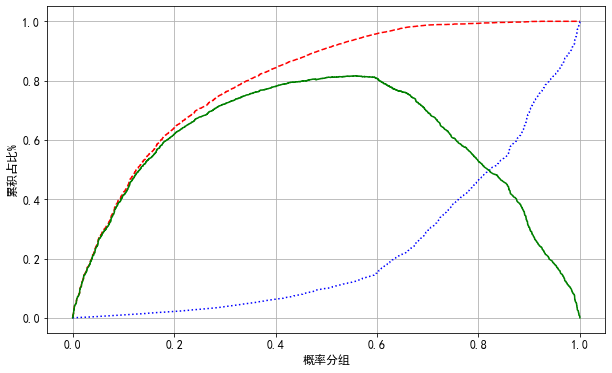

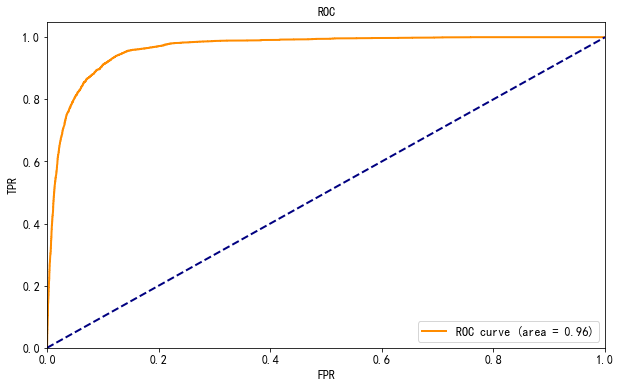

In [48]:
%matplotlib inline

####ks曲线
plt.figure(figsize=(10,6))
fontsize_1 = 12
plt.plot(np.linspace(0,1,len(tpr)),tpr,'--',color='red', label='正样本洛伦兹曲线')
plt.plot(np.linspace(0,1,len(tpr)),fpr,':',color='blue', label='负样本洛伦兹曲线')
plt.plot(np.linspace(0,1,len(tpr)),tpr - fpr,'-',color='green')
plt.grid()
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.xlabel('概率分组',fontsize=fontsize_1)
plt.ylabel('累积占比%',fontsize=fontsize_1)
print('最大KS值:',max(tpr - fpr))

####ROC曲线
plt.figure(figsize=(10,6))
lw = 2
fontsize_1 = 12
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.xlabel('FPR',fontsize=fontsize_1)
plt.ylabel('TPR',fontsize=fontsize_1)
plt.title('ROC',fontsize=fontsize_1)
plt.legend(loc="lower right",fontsize=fontsize_1)

plt.show()

## 评分卡生成

In [49]:
#########################
####评分卡生成
###保存模型的参数用于计算评分
var_woe_name.append('intercept')
##提取权重
weight_value = list(LR_model_fit.coef_.flatten())
##提取截距项
weight_value.extend(list(LR_model_fit.intercept_))
dict_params = dict(zip(var_woe_name,weight_value))


##查看训练集、验证集与测试集
y_score_train = LR_model_fit.predict_proba(x_train)[:, 1]
y_score_test = LR_model_fit.predict_proba(x_test)[:, 1]


####生成评分卡
df_score,dict_bin_score,params_A,params_B,score_base = create_score(dict_woe_map,dict_params,dict_cont_bin,dict_disc_bin)

print('参数 A 取值:',params_A)
print('参数 B 取值:',params_B)
print('基准分数:',score_base)

var_bin_score = pd.DataFrame(dict_bin_score)
print('全部',var_bin_score.shape[1],'个变量，不同取值 bins(分箱) 所对应的分数：')
var_bin_score.sort_index()


## 保存, 2022-07-05
with open('data/score_data.pkl', 'wb') as f:
    pickle.dump({
        "dict_bin_score" : dict_bin_score,
        "dict_cont_bin" : dict_cont_bin,
        "dict_disc_bin" : dict_disc_bin,
        "score_base" : score_base,
    }, f)

##计算样本评分
df_all = pd.concat([data_train,data_test],axis = 0)
df_all_score = cal_score(df_all,dict_bin_score,dict_cont_bin,dict_disc_bin,score_base)
df_all_score.score[df_all_score.score >900] = 900
print('样本最高分：',df_all_score.score.max())
print('样本最低分：',df_all_score.score.min())
print('样本平均分：',df_all_score.score.mean())
print('样本中位数得分：',df_all_score.score.median())
print('全部样本的变量得分情况：')
df_all_score

参数 A 取值: 481.8621880878296
参数 B 取值: 28.85390081777927
基准分数: 465.0
全部 13 个变量，不同取值 bins(分箱) 所对应的分数：
样本最高分： 832.0
样本最低分： 118.0
样本平均分： 548.4938276553106
样本中位数得分： 563.0
全部样本的变量得分情况：


,all_util,last_pymnt_amnt,num_rev_tl_bal_gt_0,num_tl_op_past_12m,revol_bal,tot_hi_cred_lim,total_rev_hi_lim,installment,good_rev_accts_rate,emp_length,last_pymnt_d,next_pymnt_d,term,base_score,score,target
0,0.0,-22.0,2.0,-3.0,0.0,-2.0,-2.0,-1.0,-5.0,1.0,105.0,0.0,15.0,465.0,553.0,0
1,-3.0,133.0,2.0,-3.0,0.0,-2.0,-2.0,1.0,-0.0,-0.0,-33.0,0.0,15.0,465.0,573.0,0
2,0.0,198.0,4.0,0.0,0.0,-2.0,-2.0,-8.0,-2.0,-0.0,-33.0,0.0,15.0,465.0,635.0,0
3,0.0,232.0,2.0,-3.0,0.0,2.0,-2.0,11.0,-0.0,-0.0,-33.0,0.0,15.0,465.0,689.0,0
4,0.0,-22.0,4.0,7.0,1.0,3.0,-2.0,11.0,2.0,1.0,-3.0,0.0,15.0,465.0,482.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99795,0.0,-22.0,-2.0,7.0,-0.0,-2.0,-0.0,-8.0,-5.0,-3.0,105.0,0.0,15.0,465.0,550.0,0
99796,-3.0,198.0,-5.0,7.0,-0.0,-2.0,-0.0,-4.0,-2.0,1.0,50.0,0.0,-26.0,465.0,679.0,0
99797,3.0,198.0,-2.0,-3.0,-0.0,-0.0,4.0,-1.0,-0.0,-0.0,-33.0,0.0,15.0,465.0,646.0,0
99798,-3.0,198.0,-5.0,-3.0,-1.0,6.0,9.0,11.0,-0.0,1.0,-33.0,0.0,15.0,465.0,660.0,0


In [50]:
##简单的分数区间计算
good_total = sum(df_all_score.target == 0)
bad_total = sum(df_all_score.target == 1)
score_bin = np.arange(300,950,50)
bin_rate = []
bad_rate = []
ks = []
good_num = []
bad_num = []
for i in range(len(score_bin)-1):
    ##取出分数区间的样本
    if score_bin[i+1] == 900:
        index_1 = (df_all_score.score >= score_bin[i]) & (df_all_score.score <= score_bin[i+1]) 
    else:
        index_1 = (df_all_score.score >= score_bin[i]) & (df_all_score.score < score_bin[i+1]) 
    df_temp = df_all_score.loc[index_1,['target','score']]
    ##计算该分数区间的指标
    good_num.append(sum(df_temp.target==0))
    bad_num.append(sum(df_temp.target==1))
    ##区间样本率
    bin_rate.append(df_temp.shape[0]/df_all_score.shape[0]*100)
    ##坏样本率
    bad_rate.append(df_temp.target.sum()/df_temp.shape[0]*100)
    ##以该分数为注入分数的ks值
    ks.append(sum(bad_num[0:i+1])/bad_total - sum(good_num[0:i+1])/good_total )

index_range = [f'{i}-{i+50}' for i in score_bin if i!=900]
df_result = pd.DataFrame({'good_num':good_num,'bad_num':bad_num,'bin_rate':bin_rate,
                         'bad_rate':bad_rate,'ks':ks},index=index_range) 
df_result

,good_num,bad_num,bin_rate,bad_rate,ks
300-350,0,2,0.002004,100.000000,0.000110
350-400,440,5396,5.847695,92.460589,0.292681
400-450,4413,9784,14.225451,68.915968,0.778914
450-500,7560,2133,9.712425,22.005571,0.804149
500-550,8955,472,9.445892,5.006895,0.720590
550-600,27839,215,28.110220,0.766379,0.391674
600-650,20227,32,20.299599,0.157954,0.145834
650-700,10824,2,10.847695,0.018474,0.013444
700-750,970,1,0.972946,0.102987,0.001625
750-800,426,2,0.428858,0.467290,-0.003480


观察不同分数段中，好坏信用样本频数分布:
好样本采用左侧纵轴刻度，坏样本采用右侧纵轴刻度


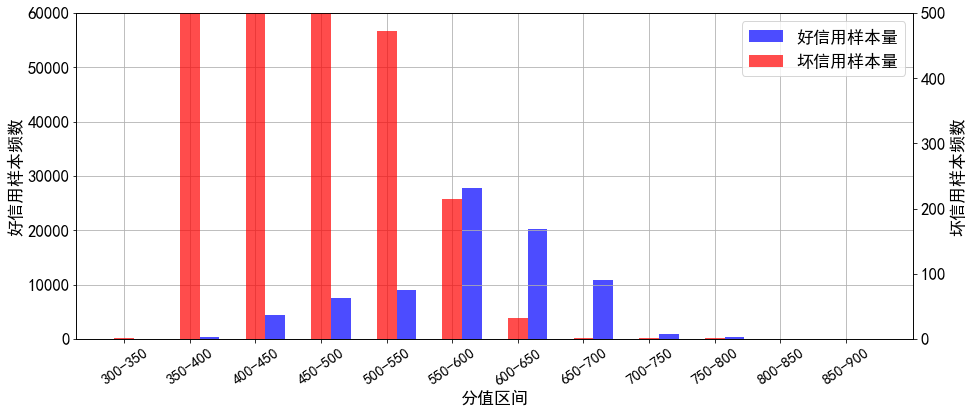

观察不同分数段中，好坏信用样本的概率密度分布：


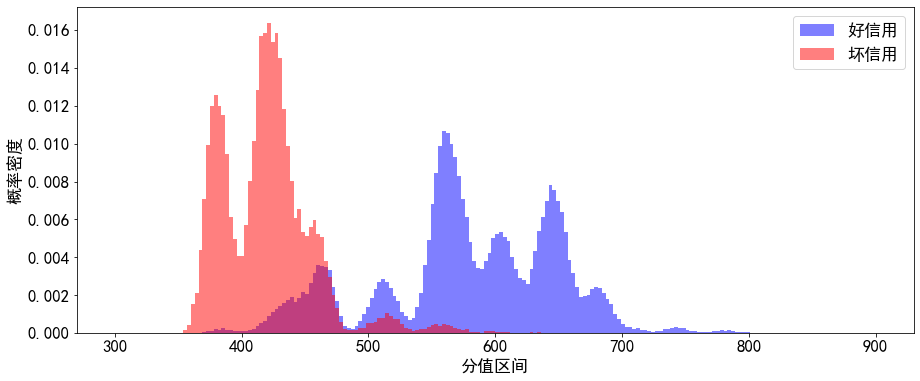

In [51]:
score_all = df_all_score.loc[:,['score','target']]
target_0_score = score_all.loc[score_all['target']==0]
target_1_score = score_all.loc[score_all['target']==1]


print('观察不同分数段中，好坏信用样本频数分布:\n好样本采用左侧纵轴刻度，坏样本采用右侧纵轴刻度')

bar_width = 0.3
fig, ax1 = plt.subplots(figsize=(15,6))
plt.bar(np.arange(0,12)+ bar_width,df_result.iloc[:,0],bar_width,alpha=0.7,color='blue', label='好信用样本量') 
ax1.set_ylabel('好信用样本频数',fontsize=17)
ax1.set_ylim([0,60000])
plt.grid(True)
plt.xlabel('分值区间',fontsize=17)
plt.xticks(np.arange(0,12),index_range,rotation=35,fontsize=15)
plt.yticks(fontsize=17)

# 共享横轴，双纵轴
ax2 = ax1.twinx()
ax2.bar(np.arange(0,12),df_result.iloc[:,1],bar_width,alpha=0.7,color='red', label='坏信用样本量')
ax2.set_ylabel('坏信用样本频数',fontsize=17)
ax2.set_ylim([0,500])
plt.yticks(fontsize=17)
plt.xlabel('分值区间',fontsize=17)

# 合并图例
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1+handles2, labels1+labels2, loc='upper right',fontsize=17)
plt.show()


print('观察不同分数段中，好坏信用样本的概率密度分布：')
plt.figure(figsize=(15,6))
plt.hist(target_0_score.iloc[:,0],bins=200,alpha=0.5,label='好信用',
         color='blue',range=(300,900),density=True,rwidth=0.3,histtype='stepfilled')
plt.hist(target_1_score.iloc[:,0],bins=200,alpha=0.5,label='坏信用',
         color='red',range=(300,900),density=True,rwidth=0.3,histtype='stepfilled')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('分值区间',fontsize=17)
plt.ylabel('概率密度',fontsize=17)
plt.legend(fontsize=17)  
plt.show()

